In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

## Загрузка аудио файла

In [2]:
speech_file = "audio/man_speech.wav"

Прослушаем исходный аудио файл:

In [3]:
ipd.Audio(speech_file)

Загрузим аудио файл с помощью librosa:

In [4]:
y, sr = librosa.load(speech_file)
print('Audio Length:', len(y))
print('Sampling Rate:', sr)

Audio Length: 189440
Sampling Rate: 22050


## Банки Фильтров Mel

Чтобы создать банк фильтров нужно:
<ol>
  <li>Преобразовать самоую низкую / высокую частоты в Mel.</li>
  <li>Создать n полос с равными интервалами точек.</li>
  <li>Преобразовать точки обратно в Гц.</li>
  <li>Округлить до ближайшего частотного элемента.</li>
  <li>Создать треугольный фильтр.</li>
</ol>
Librosa поможет нам в этом.

In [5]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)

Рассмотрим банк фильтров:

In [6]:
filter_banks.shape

(10, 1025)

10 — количество полос Mel для генерации <br>
1025 — количество компонентов БПФ / 2 + 1

Построим спектрограмму банков фильтров:

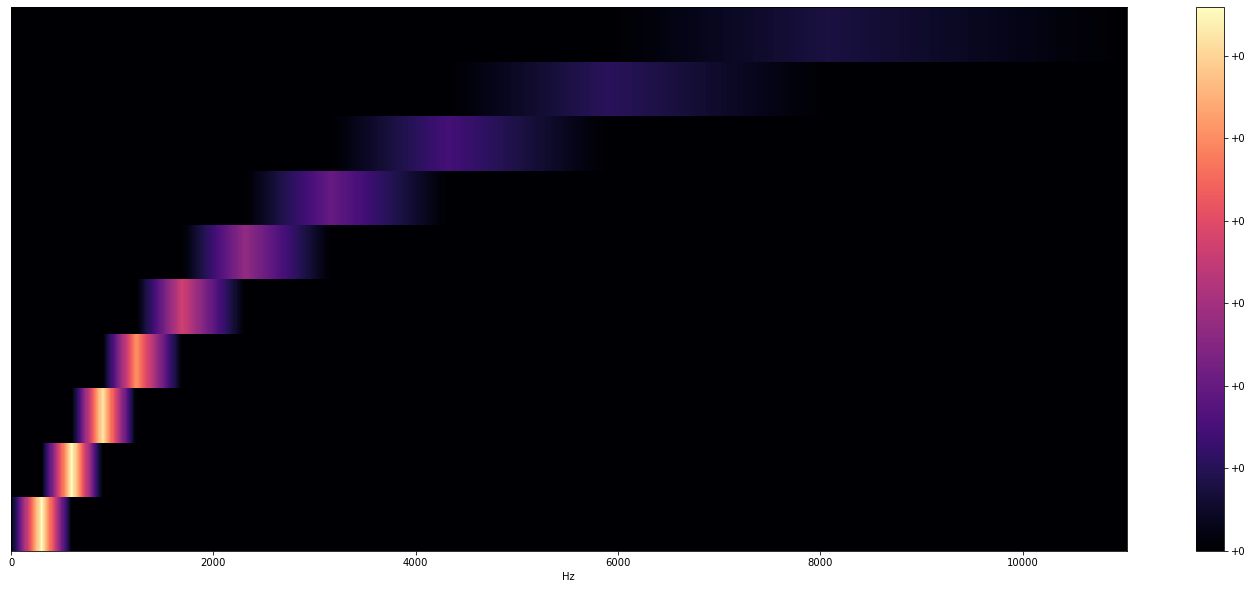

In [7]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, sr=sr, x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

## Mel Спектрограммы

Mel спектрограмма — это спектрограмма, в которой частоты преобразуются в mel шкалу.

In [8]:
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=10)

Рассмотрим mel спектрограмму:

In [9]:
mel_spectrogram.shape

(10, 371)

10 — количество полос Mel для генерации <br>
371 — произведение длительности аудио и частоты дискретизации, деленое на количество выборок между последовательными фреймами (audio_length \* sr / hop_length).

Преобразуем спектрограмму мощности (квадрат амплитуды) в децибелы (дБ):

In [10]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

In [11]:
log_mel_spectrogram.shape

(10, 371)

Визуализируем Mel спектрограмму:

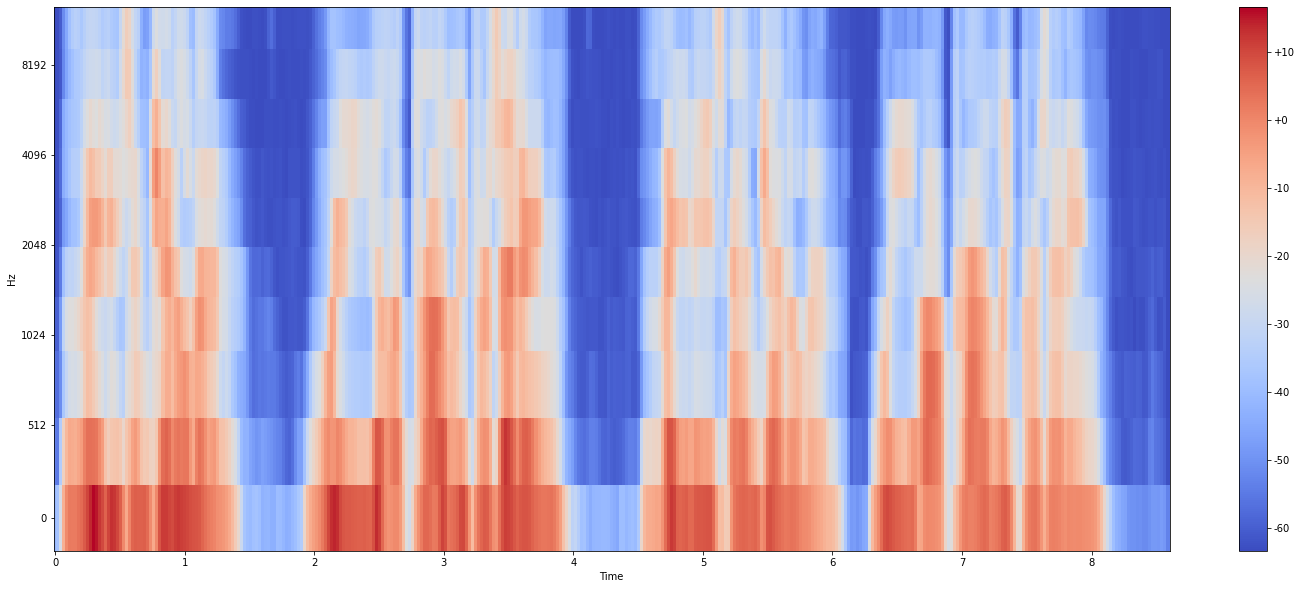

In [12]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

## PyTorch

Для получения аналогичных результатов можно воспользоваться torchaudio, который реализует выполнение функций, обычно используемых в области аудио.

In [13]:
import torch
import torchaudio

In [14]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(speech_file)

In [15]:
SPEECH_WAVEFORM.shape

torch.Size([1, 378880])

In [16]:
print('Sampling Rate:', sr)
print('Sampling Rate by Torch:', SAMPLE_RATE)

Sampling Rate: 22050
Sampling Rate by Torch: 44100


Изменим частоту дискретизации на 22050:

In [17]:
transform = torchaudio.transforms.Resample(SAMPLE_RATE, sr)
SPEECH_WAVEFORM = transform(SPEECH_WAVEFORM)

In [18]:
SPEECH_WAVEFORM.shape

torch.Size([1, 189440])

Банки Фильтров Mel:

In [19]:
filter_banks_torch = torchaudio.functional.melscale_fbanks(int(2048 // 2 + 1), sample_rate=sr, n_mels=10, f_min=0.0, 
                                                           f_max=sr / 2.0,).T

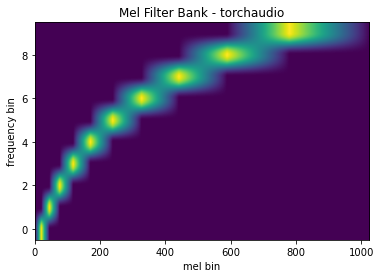

In [20]:
fig, axs = plt.subplots(1, 1)

axs.set_title("Mel Filter Bank - torchaudio")
axs.imshow(filter_banks_torch, origin="lower", aspect="auto")
axs.set_ylabel("frequency bin")
axs.set_xlabel("mel bin")

plt.show(block=False)

Mel Спектрограммы:

In [21]:
mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_spectrogram_torch = mel_spec(SPEECH_WAVEFORM)

In [22]:
mel_spectrogram_torch.shape

torch.Size([1, 10, 371])

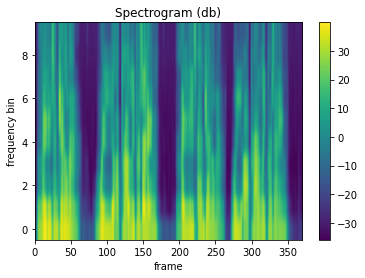

In [23]:
fig, axs = plt.subplots(1, 1)

axs.set_title("Spectrogram (db)")
im = axs.imshow(librosa.power_to_db(mel_spectrogram_torch[0]), origin="lower", aspect="auto")
axs.set_ylabel("frequency bin")
axs.set_xlabel("frame")
fig.colorbar(im, ax=axs)

plt.show(block=False)